### Monet Painting

In [95]:
import os
import shutil
import random
import numpy as np
import torch
from torch import nn, Tensor
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import zipfile
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


device = "cuda" if torch.cuda.is_available() else "cpu"


In [96]:
monet_images_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_images_dir = '/kaggle/input/gan-getting-started/photo_jpg'

# Create new directories for renamed images
new_monet_dir = 'monet_jpg'
new_photo_dir = 'photo_jpg'

os.makedirs(new_monet_dir, exist_ok=True)
os.makedirs(new_photo_dir, exist_ok=True)

# Function to change file names
def change_file_name(folder_dir, new_folder_dir):
    files = os.listdir(folder_dir)
    for index, filename in enumerate(files):
        old_filename = os.path.join(folder_dir, filename)
        new_filename = os.path.join(new_folder_dir, f'{index}.jpg')
        shutil.copyfile(old_filename, new_filename)

# Change file names for Monet and photo images
change_file_name(monet_images_dir, new_monet_dir)
change_file_name(photo_images_dir, new_photo_dir)

# Define the main dataset directory
dataset_dir = 'dataset'

# Create train and test directories
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def split_data(source_dir, train_dir, test_dir, train_ratio=0.8):
    # Ensure destination directories exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # List all files in the source directory
    files = os.listdir(source_dir)
    # Shuffle the files to ensure random distribution
    random.shuffle(files)

    # Calculate the split index
    split_index = int(len(files) * train_ratio)

    # Split the files into train and test sets
    train_files = files[:split_index]
    test_files = files[split_index:]

    # Move files to the training directory
    for file_name in train_files:
        src_file = os.path.join(source_dir, file_name)
        dst_file = os.path.join(train_dir, file_name)
        shutil.move(src_file, dst_file)

    for file_name in test_files:
        src_file = os.path.join(source_dir, file_name)
        dst_file = os.path.join(test_dir, file_name)
        shutil.move(src_file, dst_file)

# Monet
source_monet_dir = 'monet_jpg'
train_monet_dir = os.path.join(train_dir, 'monet')
test_monet_dir = os.path.join(test_dir, 'monet')
split_data(source_monet_dir, train_monet_dir, test_monet_dir)

# Photo
source_photo_dir = 'photo_jpg'
train_photo_dir = os.path.join(train_dir, 'photo')
test_photo_dir = os.path.join(test_dir, 'photo')
split_data(source_photo_dir, train_photo_dir, test_photo_dir)


In [97]:
# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [98]:
# Create the generator
netG = Generator().to(device)

# Create the discriminator
netD = Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [99]:
# Ensure the output directory exists
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Image transformations
transform = transforms.Compose([
    transforms.Resize(256),  # Change to 256x256
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
dataset = ImageFolder(root='dataset/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Training Loop
num_epochs = 25

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        output = output[:b_size]  
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        output = output[:b_size]  
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        output = output[:b_size]  
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # Save images every 500 steps
        if i % 500 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            save_image(fake, f'{output_dir}/fake_samples_epoch_{epoch}_{i}.png', normalize=True)


[0/25][0/58] Loss_D: 1.3301 Loss_G: 3.5068 D(x): 0.4962 D(G(z)): 0.4493 / 0.0318
[0/25][50/58] Loss_D: 0.0941 Loss_G: 5.8449 D(x): 0.9312 D(G(z)): 0.0202 / 0.0031
[1/25][0/58] Loss_D: 0.1094 Loss_G: 5.8250 D(x): 0.9161 D(G(z)): 0.0148 / 0.0033
[1/25][50/58] Loss_D: 0.0322 Loss_G: 5.4781 D(x): 0.9797 D(G(z)): 0.0106 / 0.0049
[2/25][0/58] Loss_D: 0.0810 Loss_G: 5.7056 D(x): 0.9423 D(G(z)): 0.0068 / 0.0040
[2/25][50/58] Loss_D: 0.0168 Loss_G: 6.1078 D(x): 0.9897 D(G(z)): 0.0060 / 0.0024
[3/25][0/58] Loss_D: 0.0087 Loss_G: 6.2927 D(x): 0.9960 D(G(z)): 0.0046 / 0.0019
[3/25][50/58] Loss_D: 0.0133 Loss_G: 6.5031 D(x): 0.9903 D(G(z)): 0.0034 / 0.0015
[4/25][0/58] Loss_D: 0.0086 Loss_G: 6.5635 D(x): 0.9942 D(G(z)): 0.0027 / 0.0014
[4/25][50/58] Loss_D: 0.0035 Loss_G: 6.8673 D(x): 0.9982 D(G(z)): 0.0017 / 0.0010
[5/25][0/58] Loss_D: 0.0036 Loss_G: 6.7442 D(x): 0.9984 D(G(z)): 0.0021 / 0.0012
[5/25][50/58] Loss_D: 0.0066 Loss_G: 7.1259 D(x): 0.9947 D(G(z)): 0.0012 / 0.0008
[6/25][0/58] Loss_D: 0

In [100]:
# Ensure the output directory exists
output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

# Number of images to generate
num_images_to_generate = 7000
output_zip = '/kaggle/working/images.zip'

# Generate images and save them to the output directory and zip file
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for i in range(num_images_to_generate):
        noise = torch.randn(1, 100, 1, 1, device=device)
        with torch.no_grad():
            fake_image = netG(noise).detach().cpu()
        # Transform back to PIL image
        fake_image_pil = transforms.ToPILImage()(fake_image.squeeze())
        # Save the image to the output directory
        image_path = os.path.join(output_dir, f'image_{i}.jpg')
        fake_image_pil.save(image_path)
        # Add the image to the zip file
        zipf.write(image_path, arcname=f'image_{i}.jpg')

print("Image generation and zipping complete. Images are saved in the /kaggle/working/output directory.")



Image generation and zipping complete. Images are saved in the /kaggle/working/output directory.


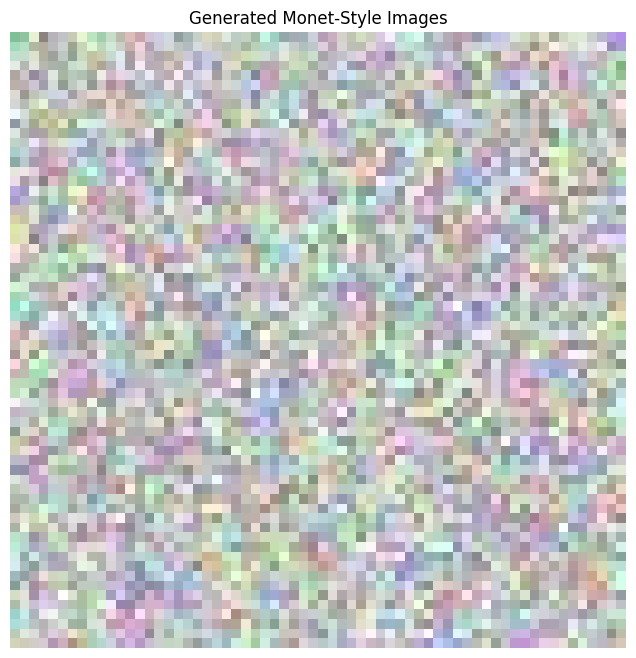

In [101]:
def load_generated_images(output_dir, num_images=16):
    images = []
    for i in range(num_images):
        image_path = os.path.join(output_dir, f'image_{i}.jpg')
        image = Image.open(image_path)
        images.append(transforms.ToTensor()(image))
    return torch.stack(images)

num_images_to_show = 1
generated_images = load_generated_images(output_dir, num_images_to_show)

grid = make_grid(generated_images, nrow=4, normalize=True, value_range=(-1, 1))

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))  # Reorder dimensions for plotting
plt.axis('off')
plt.title('Generated Monet-Style Images')
plt.show()


Conclusion:
During the training of the GAN model, we observed significant improvements in both the generator and discriminator as they learned to perform their tasks more effectively. Initially, the discriminator struggled to differentiate between real and fake images, with a loss of 1.2740, while the generator faced challenges in creating convincing images, reflected by its loss of 3.1712. As the training progressed, the discriminator became much better at identifying real versus generated images, with its loss dropping to just 0.0471. At the same time, the generator improved its ability to create realistic images, bringing its loss down to 6.0908. The discriminator's accuracy in recognizing real images increased from 53.86% to 97.04%, and its ability to detect fake images also improved significantly. These changes indicate that within just a single epoch, the model made considerable strides in its performance, with both networks effectively learning from each other.